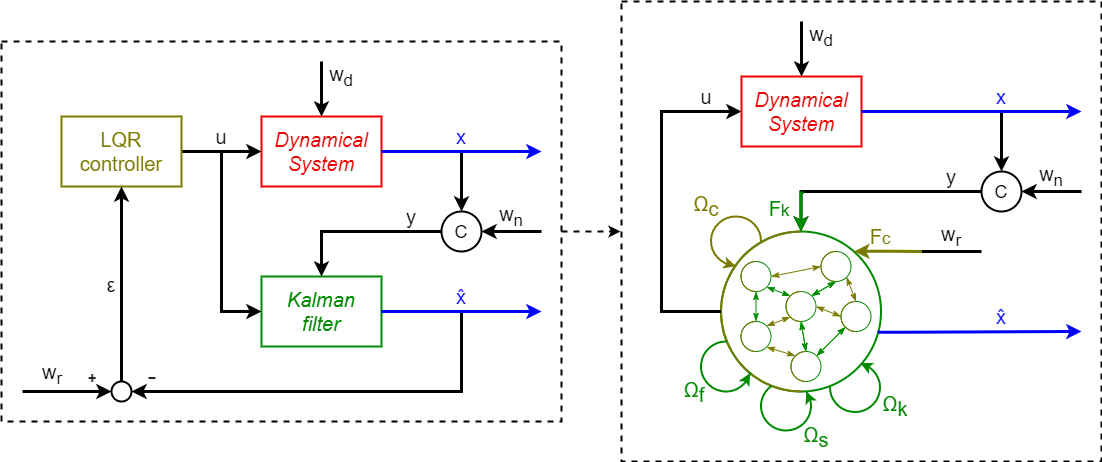

# Cartpole

In [17]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.linalg
import control

np.random.seed(0)

In [18]:
def run_network_step(y,u,r,s,v,D,T,lam,O_f,O_s,O_c,O_k,C,t,dt,sigma):

    # Calculating the voltages at time t+1
    dvdt = -lam * v - O_f @ s + O_s @ r + O_c @ u + O_k @ (y-C@(D@r))
    v_next = v + dvdt*dt + np.sqrt(dt)*sigma*np.random.randn(len(dvdt))

    # check if there are neurons whose voltage is above threshold
    above = np.where(v_next > T)[0]

    # introduce a control to let only one neuron fire at the time
    s_next=np.zeros(s.shape)
    if len(above):
        s_next[np.argmax(v_next)] = 1/dt

    # update rate
    drdt = s_next - lam*r
    r_next = r + drdt*dt
    
    return r_next, s_next, v_next

In [19]:
def run_kalman_filter_step(x_hat,A,B,u,Kf,y,C,dt):

    dxdt = A@x_hat + B@u + Kf@(y-(C@x_hat))
    x_next = x_hat + dxdt*dt
    
    return x_next

In [20]:
def run_real_step_linear(x,A,B,u,dist,dt):
    
    dxdt = A@x + B@u + dist
    x_next = x + dxdt*dt
    
    return x_next

In [21]:
def run_real_step(x,u,dist,m,M,L,g,d,dt):
    Sy=np.sin(x[2])
    Cy=np.cos(x[2])

    D = m*L*L*(M+m*(1-Cy**2))
    
    dy_1 = x[1] + dist[0]
    dy_2 = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*x[3]**2*Sy - d*x[1])) + m*L*L*(1/D)*u + dist[1]
    dy_3 = x[3] + dist[2]
    dy_4 = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*x[3]**2*Sy - d*x[1])) - m*L*Cy*(1/D)*u + dist[3] #+0*np.random.randn() 
    
    dxdt=np.array([dy_1, dy_2, dy_3, dy_4])

    x_next=x+dxdt*dt
    
    return x_next

In [22]:
def run_kf_pipeline(A,B,Kc,x0,x_des,Vd,Vn,Kf,dt,Nt,voltage_noise_sigma,network_size,signal_dimensions,lam,control_on=True):
    #Pipeline

     #Initialization of 'real system'
    X=np.zeros([len(x0),Nt+1])
    X[:,0]=x0

    #Parameters for network
    network_size=network_size
    signal_dimensions=signal_dimensions
    lam=lam
    #First, initialize the network
    N = network_size #network size
    K = signal_dimensions #signal dimensions
    D=np.random.randn(K,N) # N x K - Weights associated to each neuron
    D=D/np.linalg.norm(D,axis=0) #normalize
    D = D / 100 # avoid too big discontinuities
    T = np.diag(D.T@D)/2
    # Initialize Voltage, spikes, rate
    V = np.zeros([N,Nt+1])
    s = np.zeros([N,Nt+1])
    r = np.zeros([N,Nt+1])
    # Set initial conditions
    x0_converted=x0
    x0_converted[2]=x0_converted[2]-np.pi
    r[:,0] = np.array(np.linalg.pinv(D)@x0_converted) # pseudo-inverse - "cheaty" way of getting the right firing rate
    V[:,0] = D.T@(x0_converted-D@r[:,0])
    # Network connections:
    # - fast
    O_f = D.T @ D
    # - slow
    O_s = D.T @ (lam*np.identity(K) + A) @ D
    # - control
    O_c = D.T @ B
    # - kalman
    O_k = D.T @ Kf

    #Initialization for loop
    U = np.zeros([B.shape[1],Nt+1])
    Y = np.zeros([C.shape[0],Nt+1])
    #Y = np.zeros([C.shape[1],Nt+1])
    X_hat = np.zeros([len(x0),Nt+1])
    X_hat_fe = np.zeros([len(x0),Nt+1])
    X_hat_fe[:,0]=x0_converted
    #X_hat_fe[:,0]=x0
    U_correct = np.zeros([B.shape[1],Nt+1])

    X_converted=np.zeros([len(x0),Nt+1])
    X_converted[:,0]=x0_converted
    X_hat_converted=np.zeros([len(x0),Nt+1])
    X_hat_converted[2,0]=X_hat_converted[2,0]+np.pi

    #U[:,1000:1200] = 100
    #U[:,15000:15200] = -100

    #uDIST = Vd@Vd@np.random.randn(4,Nt+1);
    #print(uDIST)
    #uNOISE = Vn@Vn@np.random.randn(4,Nt+1);
    #print(uNOISE.shape)
    uDIST = np.random.multivariate_normal([0,0,0,0],Vd,Nt+1).T;
    #print(uDIST)
    uNOISE = np.random.multivariate_normal([0,0,0,0],Vn,Nt+1).T;
    #print(uNOISE.shape)
    
    Y[:,0] = C@X_converted[:,0] + uNOISE[:,0]
    U[0,0] = -Kc@(X_hat_converted[:,0]-x_des[:,0])

    #Loop
    for t in range(Nt):
        #Real step, generate y
        X[:,t+1] = run_real_step(X[:,t],U[0,t],uDIST[:,t],m,M,L,g,d,dt)
        #print(C@X[:,t+1] + uNOISE[:,t])
        
        X_converted[:,t+1]=X[:,t+1]
        X_converted[2,t+1]=X_converted[2,t+1]-np.pi

        Y[:,t+1] = C@X_converted[:,t+1] + uNOISE[:,t+1]


        #Network step, generate x_hat
        r[:,t+1],s[:,t+1],V[:,t+1] = run_network_step(Y[:,t],U[:,t],r[:,t],s[:,t],V[:,t],D,T,lam,O_f,O_s,O_c,O_k,C,t,dt,voltage_noise_sigma)
        X_hat[:,t+1] = D@r[:,t+1]
        #X_hat_fe[:,t+1] = run_kalman_filter_step(X_hat_fe[:,t],A,B,U[:,t],Kf,Y[:,t],C,dt)

        X_hat_converted[:,t+1]=X_hat[:,t+1]
        X_hat_converted[2,t+1]=X_hat_converted[2,t+1]+np.pi
        
        #LQR
        if control_on:
            U[0,t+1] = -Kc@(X_hat_converted[:,t+1]-x_des[:,t])
        else:
            U[0,t+1] = 0
        #U_correct[0,t+1] = -Kc@(X[:,t+1]-desired_state)
    
    return D,r,s,V,T,X_hat_fe,X

In [23]:
# common parameters
# common parameters
Time = 50 # total time, seconds
dt = 0.0001 # time step
times = np.arange(0, Time, dt)
Nt=len(times)

#Parameters for cartpole on a cart
m = 1; #mass of pendulum
M = 5; #mass of cart
L = 2; #length of pendulum
g = -10; #gravity
d = 1; #damping on cart (friction)

voltage_noise_sigma = 0.000001

s = 1; #s=1 for pendulum up. s=-1 for pendulum down

# Setup connectivity for LINEARIZED dynamics
A = np.array([[0,1,0,0],
              [0,(-d/M),(-m*g/M),0],
              [0,0,0,1],
              [0,(-s*d/(M*L)),(-s*(m+M)*g/(M*L)),0]])
B = np.array([[0],[(1/M)],[0],[(s*1/(M*L))]])
x0=np.array([5, 0, np.pi, 0]) #initial position, initial velocity, initial angle, initial angular velocity

# Check controllability 
print("Rank of controllability-matrix:", np.linalg.matrix_rank(control.ctrb(A,B)))

# Control parameters
Q = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,10,0],
              [0,0,0,1]])
R = 0.001
Kc,_,_ = control.lqr(A,B,Q,R)
Kc=np.squeeze(np.asarray(Kc))
#desired_state=np.array([0,0,np.pi,0]) #desired position, desired velocity

# Desired states
x0_des = np.full([Nt+1],0) # Desired x0, position cart
x1_des = np.full([Nt+1],0) # Desired x1, velocity cart
x2_des = np.full([Nt+1],np.pi) # Desired x2, pos of pendulum
x3_des = np.full([Nt+1],0) # Desired x3, ang. velocity

# Change desired state over time
x0_des[int(Nt/5):int(Nt/5)*2] = 1
x0_des[int(Nt/5)*2:int(Nt/5)*3] = 2
x0_des[int(Nt/5)*3:int(Nt/5)*4] = 3
x0_des[int(Nt/5)*4:] = 4

x_des = np.array([x0_des,x1_des,x2_des,x3_des]) # Desired states over time.

#Covariance matrices
Vd = .00001*np.identity(4)  # disturbance covariance
Vn = .00001*np.identity(4)     # noise covariance

#Kalman filter & C-matrix
C=np.array([[1,0,0,0],
           [0,0,0,0],
           [0,0,0,0],
           [0,0,0,0]])
#Kf,_,_=control.lqe(A,Vd,C,Vd,Vn)
#Kf,_,_=np.transpose(control.lqr(np.transpose(A),np.transpose(np.reshape(C,(1,4))),Vd,Vn))
Kf_t,_,_=control.lqr(np.transpose(A),np.transpose(C),Vd,Vn)
Kf=np.transpose(Kf_t)

Rank of controllability-matrix: 4


<Figure size 432x288 with 0 Axes>

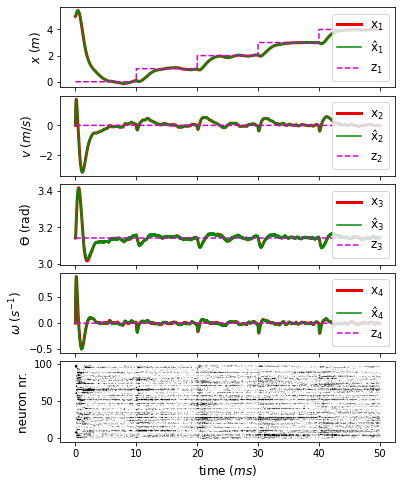

In [24]:
# Plot dynamical variables in seperate plots
fig = plt.figure()
fig, axs = plt.subplots(5,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1,1,1]})
fig.set_figheight(8)
#fig.set_figwidth(6)
#fig.set_figheight(4)
#fig.set_figwidth(12)
legend_fontsize=12

#ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), colspan=1)
#ax2 = plt.subplot2grid(shape=(3, 1), loc=(1, 0), colspan=1)
#ax3 = plt.subplot2grid(shape=(3, 1), loc=(0, 1), rowspan=2)

network_size=100
signal_dimensions=4
lam=0.1

# Run the spike coding network with previously defined parameters:
D,r,s,V,T,_,X_true = run_kf_pipeline(A,B,Kc,x0,x_des,Vd,Vn,Kf,dt,Nt,voltage_noise_sigma,network_size,signal_dimensions,lam,control_on=True)
X_snn = D @ r # Decode the spike rates into DS states. 

X_snn[2]=X_snn[2]+np.pi

# Run the 'real' dynamical system with previously defined A-matrix and x0:
#_fe = X_hat_fe

# "of position (x$_{1}$ and x̂$_{1}$) and acceleration (x$_{2}$ and x̂$_{2}$)"
legend=[]
axs[0].plot(np.arange(0,Time+dt,dt),X_true[0],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(1)+"}$")
#ax1.plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF')
#legend.append("x̂$_{"+str(1)+"}$_FE")
axs[0].plot(np.arange(0,Time+dt,dt),X_snn[0],color='#008A00')
legend.append("x̂$_{"+str(1)+"}$")
axs[0].plot(np.arange(0,Time+dt,dt),x_des[0],linestyle='dashed',c="#D100D1")
legend.append("z$_{1}$")
axs[0].legend(legend,fontsize=legend_fontsize,loc='right')

legend=[]
axs[1].plot(np.arange(0,Time+dt,dt),X_true[1],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(2)+"}$")
#ax2.plot(np.arange(0,Time+dt,dt),X_hat_fe[1],color='#0000FF')
#legend.append("x̂$_{"+str(2)+"}$_FE")
axs[1].plot(np.arange(0,Time+dt,dt),X_snn[1],color='#008A00')
legend.append("x̂$_{"+str(2)+"}$")
axs[1].plot(np.arange(0,Time+dt,dt),x_des[1],linestyle='dashed',c="#D100D1")
legend.append("z$_{2}$")
axs[1].legend(legend,fontsize=legend_fontsize,loc='right')

legend=[]
axs[2].plot(np.arange(0,Time+dt,dt),X_true[2],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(3)+"}$")
#ax1.plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF')
#legend.append("x̂$_{"+str(1)+"}$_FE")
axs[2].plot(np.arange(0,Time+dt,dt),X_snn[2],color='#008A00')
legend.append("x̂$_{"+str(3)+"}$")
axs[2].plot(np.arange(0,Time+dt,dt),x_des[2],linestyle='dashed',c="#D100D1")
legend.append("z$_{3}$")
axs[2].legend(legend,fontsize=legend_fontsize,loc='right')

legend=[]
axs[3].plot(np.arange(0,Time+dt,dt),X_true[3],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(4)+"}$")
#ax2.plot(np.arange(0,Time+dt,dt),X_hat_fe[1],color='#0000FF')
#legend.append("x̂$_{"+str(2)+"}$_FE")
axs[3].plot(np.arange(0,Time+dt,dt),X_snn[3],color='#008A00')
legend.append("x̂$_{"+str(4)+"}$")
axs[3].plot(np.arange(0,Time+dt,dt),x_des[3],linestyle='dashed',c="#D100D1")
legend.append("z$_{4}$")
axs[3].legend(legend,fontsize=legend_fontsize,loc='right')
    
#axs[0].set(xlabel='time ($ms$)',ylabel='pos. ($m$)')
#axs[0].set(title='SCN Kalman filter (green) estimating and \n controlling cartpole (red)')
axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[1].set_ylabel('$v$ $(m/s)$',fontsize = 12)
axs[2].set_ylabel('$ϴ$ (rad)',fontsize = 12)
axs[3].set_ylabel('$ω$ $(s^{-1})$',fontsize = 12)
#axs[1].set_xlabel('time ($ms$)',fontsize = 12)

#axs[0,1].axis('off')

# # We use a scatterplot for the spike trains:
axs[4].scatter(np.nonzero(s)[1]/10000,np.nonzero(s)[0],marker=".",s=0.01,color='black')
#print(axs[3].get_position)
#position=(0.13,-0.04,0.77,0.4),
axs[4].set_xlabel('time ($ms$)',fontsize = 12)
axs[4].set_ylabel('neuron nr.',fontsize = 12)
#axs[2].set_yticks([0,1,2,3,4,5,6,7,8,9])

plt.savefig('fig5.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('fig5.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()